## Using Regularized Linear Regression to predict house prices (Ames data set)

Author: David Kradolfer, May 2017

In this notebook, I will use two linear regression methods, the Lasso and Ridge regression, to predict sale prices of properties in Ames, Iowa, between 2006 and 2010. The training and test data can be downloaded from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

A description of the variables of the data set can be found [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt), and there is also a [publication](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) on the data set by Dean De Cock.

Evaluation metric:  Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# set options to display all rows and columns of objects:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# load the data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Exploration and Preprocessing

Finding and removing outliers, as indicated in the [publication](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) of the data set.

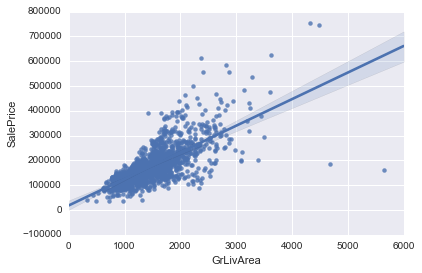

In [3]:
sns.regplot(train_df.GrLivArea, train_df.SalePrice);

The author of the data set recommends to remove any houses with GrLivArea > 4000 square feet. As the 'SaleCondition' column (2nd last) below shows, 2 of them were partial sales which likely explains their low price despite the very large living area.

There is another house with GrLivArea > 4000 in the test data, which obviously can't be removed.

In [4]:
train_df[(train_df.GrLivArea > 4000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [5]:
# keep only houses with < 4000 square feet:
train_df = train_df[train_df.GrLivArea < 4000] 


The histogram below shows that the distribution of SalePrice is highly skewed, a log transformation to obtain approximately a normal distribution is therefore required.

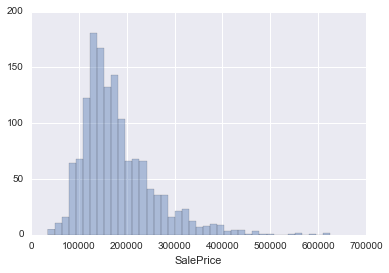

In [6]:
sns.distplot(train_df.SalePrice, kde = False);

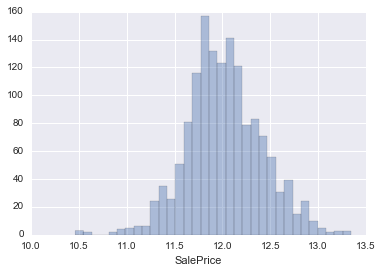

In [7]:
train_df.SalePrice = np.log1p(train_df.SalePrice)
sns.distplot(train_df.SalePrice, kde = False);

To get an overview of the data, it is useful to plot a correlation matrix (includes only numerical variables without missing data). Some varibles highly correlate with 'SalePrice', e.g. 'OverallQual' and 'GrLivArea'. Other variables correlate with each other, e.g. 'GarageCars' and 'GarageArea', which makes a lot of sense. But since Lasso and Ridge Regression don't require manual feature selection, I won't actually use the correlations.

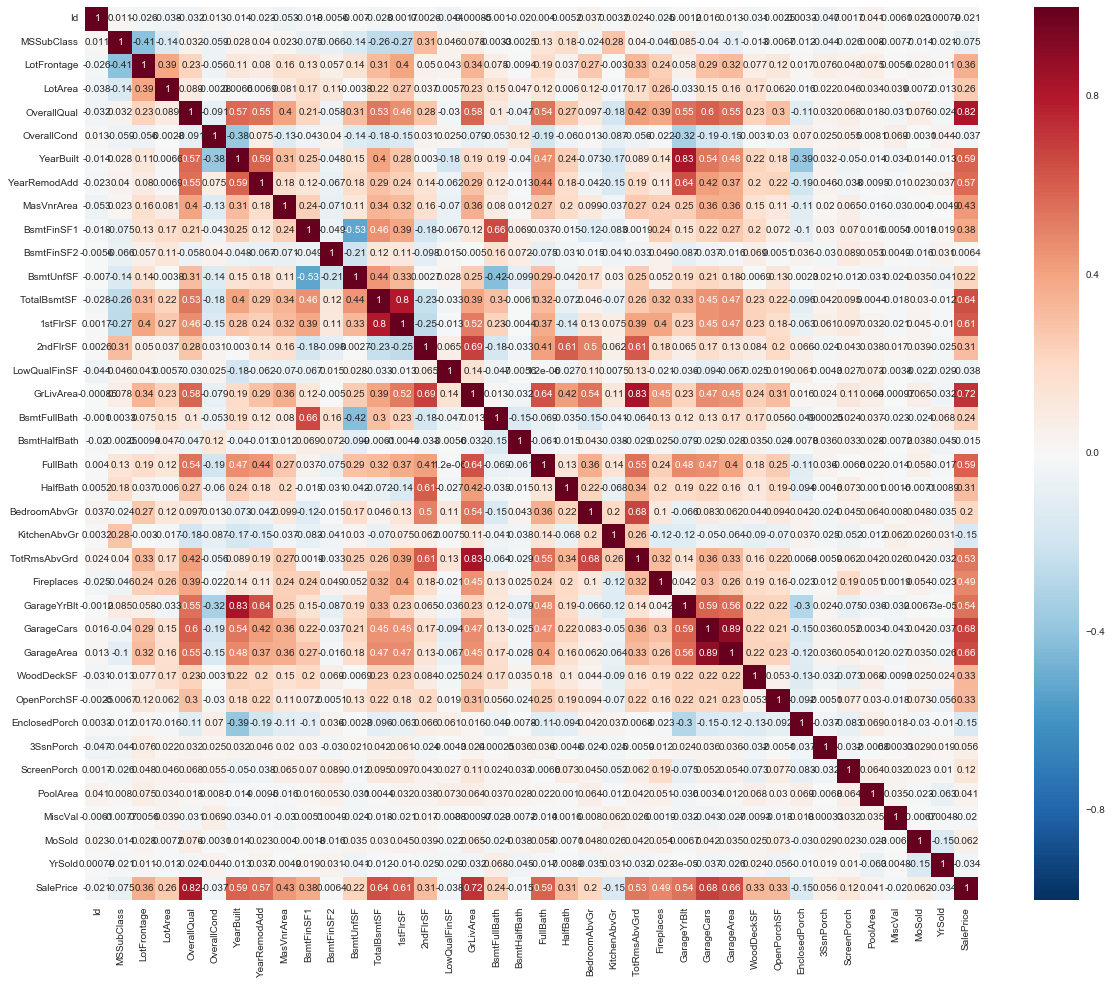

In [8]:
corr = train_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

Creating a single dataframe with all the features (except 'Id'). This will be useful to estimate missing values.

In [9]:
all_data = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'],
                      test_df.loc[:,'MSSubClass':'SaleCondition']))
print('dimensions of all_data:', all_data.shape)
all_data.head()

dimensions of all_data: (2915, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


The first feature 'MSSubClass' identifies the type of dwelling involved in the sale. The numbers are codes for different types, therefore this should be a nominal variable (and not an ordinal). There is no relationship that higher numbers have higher (or lower) prices, but there are clear differences between the classes, e.g. class 30 (= 1-STORY 1945 & OLDER) is much cheaper than class 60 (= 2-STORY 1946 & NEWER). I will convert the variable to a string so that it will later be coded as a dummy variable (like the other string variables).

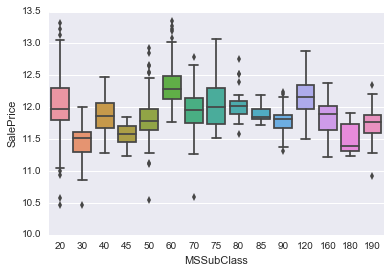

In [10]:
all_data.MSSubClass = all_data.MSSubClass.astype(str)
sns.boxplot(train_df.MSSubClass, train_df.SalePrice);

'MoSold' (month in which the house was sold) is currently also an ordinal variable, which is questionable. The highest number of sales is between May and July, while there are few sales in autumn and winter. But 'MoSale' has little effect on the Sale Price. I have tried converting 'MoSold' into a nominal variable, but this gave a worse model than just leaving the variable as is or deleting it. I will therefore just keep it as it is (as shown in the correlation matrix above, there might indeed be a minimal trend for prices to increase during the year).

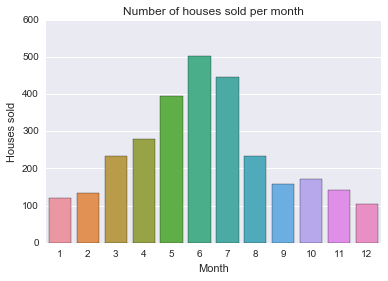

In [11]:
sns.barplot(x = all_data.MoSold.value_counts().index, y = all_data.MoSold.value_counts());
plt.xlabel('Month');
plt.ylabel('Houses sold');
plt.title('Number of houses sold per month');

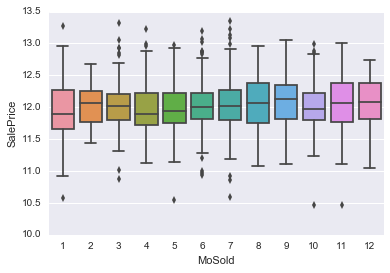

In [12]:
sns.boxplot(train_df.MoSold, train_df.SalePrice);

Some features have a lot of missing values. Of the 2915 observations, there are over 2700 missing values in 'PoolQC', 'MiscFeature', 'Alley'. I will therefore delete these 3 features.

In [13]:
print('# of missing values: \n')
print(all_data.isnull().sum().nlargest(10))

# of missing values: 

PoolQC          2907
MiscFeature     2810
Alley           2717
Fence           2345
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
dtype: int64


In [14]:
all_data.drop(['Alley','PoolQC','MiscFeature'], axis = 1, inplace= True)

Some more preprocessing to deal with skewed features, categorical variables and missing data:

In [15]:
# log transform skewed numeric features:
from scipy.stats import skew

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.85]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [16]:
# create dummy variables:
all_data = pd.get_dummies(all_data)

In [17]:
# fill NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [18]:
# create matrices for sklearn:
X_train = all_data[:train_df.shape[0]]
X_test = all_data[train_df.shape[0]:]
y_train = train_df.SalePrice

### Models

I will try two different models, Lasso and Ridge. They use different regularization techniques to shrink the coefficients of the model (Lasso: l_1, Ridge: l_2). With the Lasso, coefficients are often close to 0, but not exactly 0. With Ridge regression, some coefficients can become exactly 0.

#### The Lasso

In [19]:
# training the model:
# I added some alpha values around 0.0005 after seeing that the picked alpha is in this region
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003])
model_lasso.fit(X_train, y_train)
print('LassoCV picked alpha =', model_lasso.alpha_)

# storing the coefficients of the model:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns, name='Lasso Coefficients')

LassoCV picked alpha = 0.0004


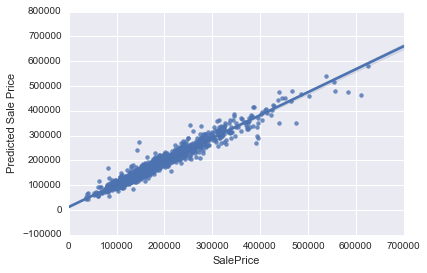

In [20]:
# predict prices of X_train and plot them against the real prices:
pred_train_lasso = pd.Series(np.exp(model_lasso.predict(X_train)), name='Predicted Sale Price')
sns.regplot(np.exp(y_train), pred_train_lasso);

In [21]:
# calculate the RMSE on the training data (which is unrealistically low as the model was trained on all of this data) 
print('Root-Mean-Squared-Error of training data:') 
print(np.sqrt(mean_squared_error(y_train, np.log(pred_train_lasso))), '\n')

# this predicts the RMSE using cross-validation on data that was not used to train the model
rmse = np.sqrt(-cross_val_score(model_lasso, X_train, y_train, scoring='neg_mean_squared_error', cv = 10))
print('Expected Root-Mean-Squared-Error for new data (using cross-validation):')
print(np.mean(rmse))

Root-Mean-Squared-Error of training data:
0.0967158214879 

Expected Root-Mean-Squared-Error for new data (using cross-validation):
0.10737400781


Plotting the residuals, we can see that they are nicely distributed around 0:

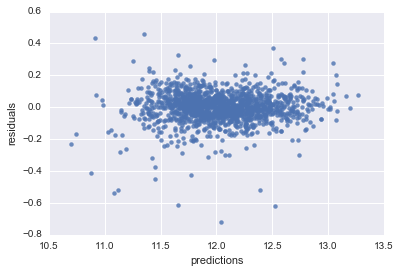

In [22]:
preds = pd.DataFrame({'predictions':model_lasso.predict(X_train), 'true':y_train})
preds['residuals'] = preds['true'] - preds['predictions']
sns.regplot(x = 'predictions', y = 'residuals', data=preds, fit_reg=False);

In [23]:
# finally, predicting the prices of X_test:
predictions_lasso = pd.DataFrame()
predictions_lasso['Id'] = test_df.Id
predictions_lasso['SalePrice'] = np.exp(model_lasso.predict(X_test))

In [24]:
# save the predictions:
predictions_lasso.to_csv('predictions_lasso.csv', index = False)

Submitting the Lasso predictions results in a RMSE score of 0.11837 on the public leaderboard.

#### Ridge Regression

Let's see how Ridge Regression performs. This is basically a repetition of the code above, but using RidgeCV instead of LassoCV.

In [25]:
# training the model:
# I added some alpha values around 8 after seeing that the picked alpha is in this region
model_ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 8, 8.2, 8.3, 8.4, 9, 10, 15, 30, 50, 75])
model_ridge.fit(X_train,y_train)
print('RidgeCV picked alpha =', model_ridge.alpha_)

# storing the coefficients of the model:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns, name='Ridge Coefficients')

RidgeCV picked alpha = 8.3


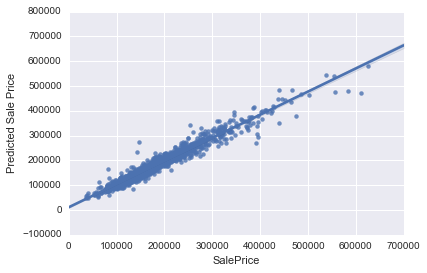

In [26]:
# predict prices of X_train and plot them against the real prices:
pred_train_ridge =pd.Series(np.exp(model_ridge.predict(X_train)), name='Predicted Sale Price')
sns.regplot(np.exp(y_train), pred_train_ridge);

In [27]:
# Calculate the RMSE on the training data (which is unrealistically low as the model was trained on all of this data) 
print('Root-Mean-Squared-Error of training data:') 
print(np.sqrt(mean_squared_error(y_train, np.log(pred_train_ridge))), '\n')

# this predicts the RMSE using cross-validation on data that was not used to train the model
rmse= np.sqrt(-cross_val_score(model_ridge, X_train, y_train, scoring='neg_mean_squared_error', cv = 10))
print('Expected Root-Mean-Squared-Error for new data (using cross-validation):')
print(np.mean(rmse))

Root-Mean-Squared-Error of training data:
0.0936373526802 

Expected Root-Mean-Squared-Error for new data (using cross-validation):
0.109011952429


Again, the residuals look good:

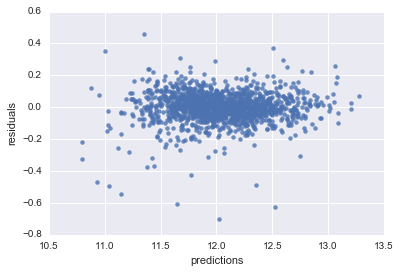

In [28]:
preds = pd.DataFrame({'predictions':model_ridge.predict(X_train), 'true':y_train})
preds['residuals'] = preds['true'] - preds['predictions']
sns.regplot(x = 'predictions', y = 'residuals', data=preds, fit_reg=False);

In [29]:
# finally, predicting the prices of X_test:
predictions_ridge = pd.DataFrame()
predictions_ridge['Id'] = test_df.Id
predictions_ridge['SalePrice'] = np.exp(model_ridge.predict(X_test))

In [30]:
# save the predictions:
predictions_ridge.to_csv('predictions_ridge.csv', index = False)

The Ridge Predictions give a LB score of 0.11705 (currently top 11%), which is a bit better than the Lasso. The Ridge model also gives a lower RMSE on the training data, but surprisingly the Ridge RMSE is higher when using the cross-validation function. 

It might also be useful to make predictions that are the average of the two models. This gives a LB score of 0.11717, which is a bit higher, but close to the Ridge predictions.

In [31]:
predictions_ridge_lasso = pd.DataFrame()
predictions_ridge_lasso['Id'] = test_df.Id
predictions_ridge_lasso['SalePrice'] = (predictions_ridge.SalePrice + predictions_lasso.SalePrice)/2

predictions_ridge_lasso.to_csv('predictions_lasso_ridge.csv', index = False)

#### Model coefficients

Let's take a look at the coefficients of both models:

In [32]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])

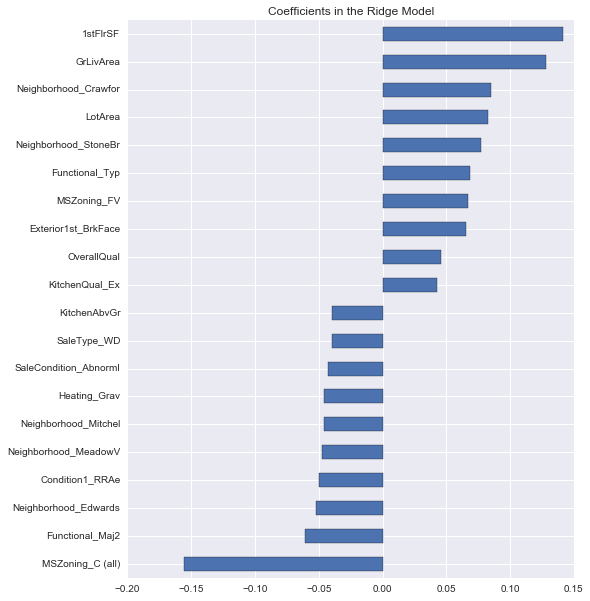

In [33]:
#matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
plt.figure(figsize=(8,10))
imp_coef_ridge.plot(kind = 'barh');
plt.title('Coefficients in the Ridge Model');

In [34]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])

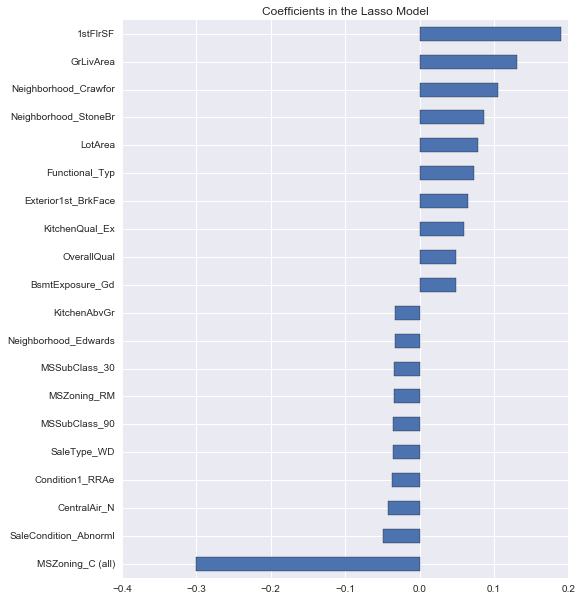

In [35]:
plt.figure(figsize=(8,10))
imp_coef_lasso.plot(kind = 'barh');
plt.title('Coefficients in the Lasso Model');

In [36]:
print(len(coef_ridge[coef_ridge ==0]), 'coefficents = 0 in the Ridge model')
print(len(coef_ridge[coef_ridge !=0]),'coefficents not = 0 in the Ridge model')

1 coefficents = 0 in the Ridge model
292 coefficents not = 0 in the Ridge model


In [37]:
print(len(coef_lasso[coef_lasso ==0]), 'coefficents = 0 in the Lasso model')
print(len(coef_lasso[coef_lasso !=0]),'coefficents not = 0 in the Lasso model')

172 coefficents = 0 in the Lasso model
121 coefficents not = 0 in the Lasso model


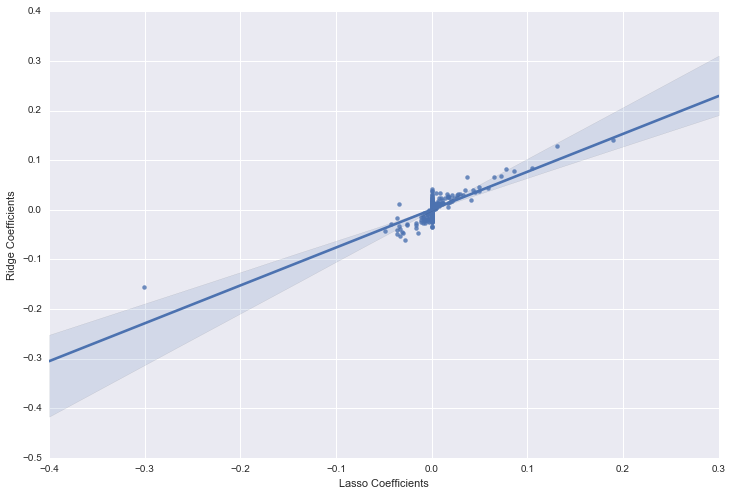

In [38]:
plt.figure(figsize=(12,8))
sns.regplot(coef_lasso, coef_ridge);

We can see that there is some correlation between the coefficients (as expected), but it is not that strong. 172 of the parameters are set to 0 in the Lasso, only 1 in the Ridge model.

#### Conclusion

In conclusion, both the Lasso and Ridge Regression make very good predictions on the data, but Ridge is slighty better. There are other techniques like random forest and gradient boosting which I have not tried and it would be possible to do further feature engineering. Looking at the other submissions on Kaggle, there is still room for improvement, but it is quite limited (RMSE scores on the leaderboard below 0.112 are very rare, compared to 0.117 of this Ridge model)